In [1]:
from aug_util import *
from wv_util import *
from PIL import ImageFont
import matplotlib.pyplot as plt
import numpy as np
import csv
import skimage
from skimage.io import imread
import rasterio
import pandas
%matplotlib inline

In [81]:
# Processes an xView GeoJSON file
# INPUT: filepath to the GeoJSON file
# OUTPUT: Bounding box coordinate array, Chip-name array, and Class-id array
def get_labels(fname):
    """
    Gets label data from a geojson label file
    Args:
        fname: file path to an xView geojson label file
    Output:
        Returns three arrays: coords, chips, and classes corresponding to the
            coordinates, file-names, and classes for each ground truth.
    """
    x_buffer = 15
    y_buffer = 15
    right_shift = 5 # how much shift to the right 
    offset_vector = np.array([-x_buffer + right_shift, y_buffer, x_buffer + right_shift, -y_buffer])  # shift to the rihgt
    with open(fname) as f:
        data = json.load(f)
    coords = np.zeros((len(data['features']),4))
    chips = np.zeros((len(data['features'])),dtype="object")
    classes = np.zeros((len(data['features'])))
    uids = np.zeros((len(data['features'])))
    for i in tqdm(range(len(data['features']))):
        if data['features'][i]['properties']['bb'] != []:
            try:
                b_id = data['features'][i]['properties']['Joined lay']
                bbox = data['features'][i]['properties']['bb'][1:-1].split(",")
                val = np.array([int(num) for num in data['features'][i]['properties']['bb'][1:-1].split(",")])
                ymin = val[3]
                ymax = val[1]
                val[1] =  ymin
                val[3] = ymax
                chips[i] = b_id
                classes[i] = data['features'][i]['properties']['type']
                uids[i] = int(data['features'][i]['properties']['uniqueid'])
            except:
                  pass
            if val.shape[0] != 4:
                print("Messed up: %d!" % i)
            else:
                coords[i] = val
        else:
            chips[i] = 'None'

    coords = np.add(coords, offset_vector)

    return coords, chips, classes, uids

In [82]:
coords, chips, classes, uids = get_labels_w_uid('../dssg_data/harvey_ms_2class_fixedprecision.geojson')

100%|██████████| 126937/126937 [00:00<00:00, 146922.96it/s]


In [83]:
print(coords[1000], chips[1000], classes[1000], uids[1000])

[ 314. 1155.  380. 1092.] 20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif 2.0 1025.0


In [84]:
import numpy as np
from PIL import Image
import tensorflow as tf
from PIL import Image, ImageDraw
import skimage.filters as filters
from PIL import Image, ImageFont, ImageDraw, ImageEnhance


In [85]:
def draw_bboxes(img, boxes, uids):
    """
    A helper function to draw bounding box rectangles on images
    Args:
        img: image to be drawn on in array format
        boxes: An (N,4) array of bounding boxes
    Output:
        Image with drawn bounding boxes
    """
    source = Image.fromarray(img)
    draw = ImageDraw.Draw(source)
    w2,h2 = (img.shape[0],img.shape[1])
    
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 15)
    #font = ImageFont.truetype('arial.ttf', 24)


    idx = 0

    for b in boxes:
        xmin,ymin,xmax,ymax = b
        
        for j in range(3):
            draw.rectangle(((xmin+j, ymin+j), (xmax+j, ymax+j)), outline="red")
        idx +=1
    print(b)
    return source


/home/ubuntu/dssg/dssg_data/image_tiles_aws/20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif
(3, 2048, 2048)
[1553.  772. 1608.  719.]


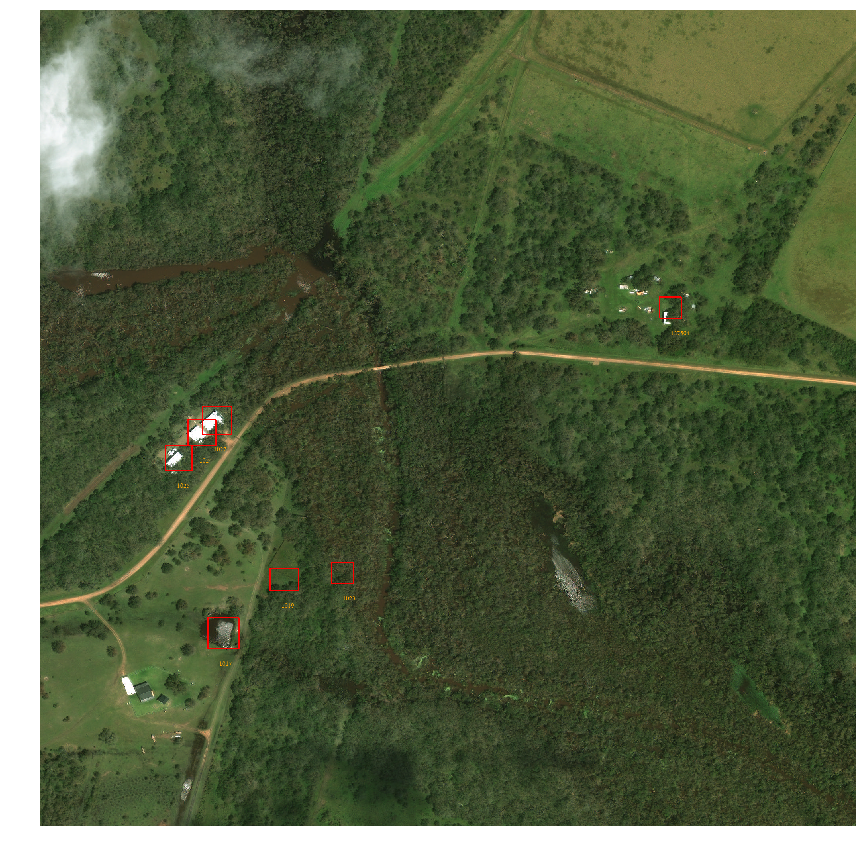

In [86]:
#Load an image
path = '/home/ubuntu/dssg/dssg_data/image_tiles_aws/'
chip_name = '20170829_1040010032211E00_2110200_jpeg_compressed_03_09.tif' # with blackout


chip_fullname = path + chip_name
print(chip_fullname)
with rasterio.open(chip_fullname, "r") as r:
    arr = r.read()
    print(arr.shape)
    arr = np.rollaxis(arr,0,3)
    coords_chip = coords[chips==chip_name]
    classes_chip = classes[chips==chip_name].astype(np.int64)
    uids_chip = uids[chips == chip_name].astype(np.int64)
    #labelled = aug.draw_bboxes(arr,coords_chip[classes_chip ==1])
    labelled = draw_bboxes_withindex(arr,coords_chip, uids_chip)

#labelled = aug.draw_bboxes(arr,coords[classes ==1])
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(labelled)

# print(arr.shape)
# plt.figure(figsize=(10,10))
# plt.axis('off')
# plt.imshow(arr)

In [87]:
#We only want to coordinates and classes that are within our chip
coords = coords[chips=='20170831_105001000B95E100_2131131_jpeg_compressed_02_09.tif']
classes = classes[chips=='20170831_105001000B95E100_2131131_jpeg_compressed_02_09.tif'].astype(np.int64)

print(coords)

[[ 653. 1391.  705. 1343.]
 [ 207. 1278.  261. 1220.]
 [1446. 1568. 1492. 1522.]
 ...
 [1677. 2130. 1906. 1939.]
 [ 482. 2088.  563. 1995.]
 [ 565. 2082.  618. 2002.]]


In [18]:
#Load the class number -> class string label map
labels = {}
with open('class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

In [20]:
#We can find which classes are present in this image
print([labels[i] for i in np.unique(classes)])

[]


In [6]:
#We can chip the image into 500x500 chips
c_img, c_box, c_cls = wv.chip_image(img = arr, coords= coords, classes=classes, shape=(500,500))
print("Num Chips: %d" % c_img.shape[0])

Num Chips: 30


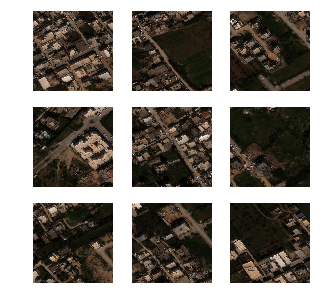

In [7]:
#We can plot some of the chips
fig,ax = plt.subplots(3)
fig.set_figheight(5)
fig.set_figwidth(5)

for k in range(9):
    plt.subplot(3,3,k+1)
    plt.axis('off')
    plt.imshow(c_img[np.random.choice(range(c_img.shape[0]))])

plt.show()

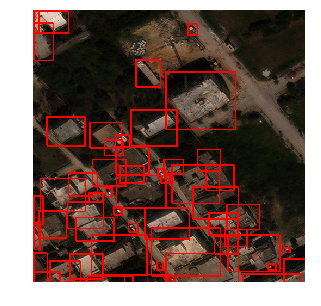

In [8]:
#We can visualize the chips with their labels
ind = np.random.choice(range(c_img.shape[0]))
labelled = aug.draw_bboxes(c_img[ind],c_box[ind])
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(labelled)

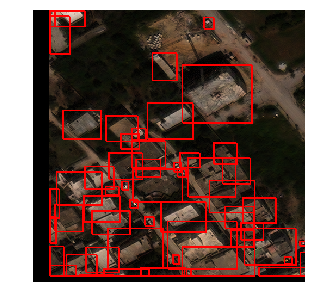

In [9]:
#We can shift the chips
i1,b1 = aug.shift_image(c_img[ind],c_box[ind])
a1 = aug.draw_bboxes(i1,b1)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a1)

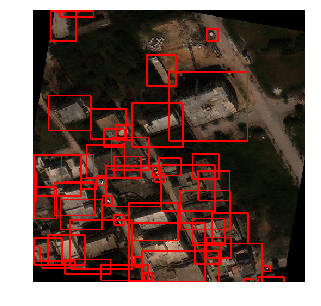

In [10]:
#We can rotate the chips
center = (int(c_img[ind].shape[0]/2),int(c_img[ind].shape[1]/2))
i2,b2 = aug.rotate_image_and_boxes(c_img[ind],10, center, c_box[ind])
a2 = aug.draw_bboxes(i2,b2)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(a2)

In [11]:
#There are other augmentations available in 'aug_util.py'
#From here, you can save out the chipped images to a TFRecord or other medium
#Use 'process_wv.py' to create a TFRecord file from xView imagery